In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_49_50_51_52.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_45_46_47_48.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_05_06_07_18.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_29_30_31_32.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_25_26_27_28.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_33_34_36.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_53_54_55_56.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_41_42_43_44.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/extra_infos/README_38_39_40.txt
/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/02421.csv
/kaggle/input/nasa-battery-dataset/cleaned_dataset/data/04530.csv
/kaggle/input/nasa-battery-dataset/c

In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define functions for battery management system optimization
def schedule_maintenance(battery_index):
    """
    Schedules maintenance for the battery with the given index.

    Parameters:
    - battery_index (int): Index of the battery requiring maintenance.

    Returns:
    None
    """
    print(f"Scheduling maintenance for battery {battery_index}")

def adjust_charging_rate(battery_index, rate):
    """
    Adjusts the charging rate of the battery with the given index.

    Parameters:
    - battery_index (int): Index of the battery.
    - rate (float): Charging rate to be applied.

    Returns:
    None
    """
    print(f"Adjusting charging rate for battery {battery_index} to {rate}")

def manage_temperature(battery_index, temperature_threshold):
    """
    Manages the temperature of the battery with the given index.

    Parameters:
    - battery_index (int): Index of the battery.
    - temperature_threshold (float): Threshold temperature for management.

    Returns:
    None
    """
    print(f"Managing temperature for battery {battery_index} with threshold {temperature_threshold}")


In [4]:
# Load data
data_folder = "/kaggle/input/nasa-battery-dataset/cleaned_dataset"
meta_data = pd.read_csv(os.path.join(data_folder, "metadata.csv"))

In [5]:
# Select the type of data (e.g., charge or discharge)
selected_type = 'charge'
selected_data = meta_data[meta_data['type'] == selected_type]
selected_files = selected_data['filename'].values

In [7]:

# Feature Engineering
selected_dfs = []
for file in selected_files:
    df = pd.read_csv(os.path.join(data_folder, "data", file))
    # Select a row randomly starting from the middle
    row = np.random.randint(len(df) // 2, len(df))
    time = df.iloc[row]['Time']
    rul = df.iloc[-1]['Time'] - time

    # Aggregate features before the selected row
    aggops = ['mean', 'std']  # Select aggregation operations
    aggs = df.iloc[:row].agg(aggops).to_dict()
    features = df.iloc[row].to_dict()
    features['id'] = f"{file.split('.')[0]}"
    features['RUL'] = rul
    for k, v in aggs.items():
        if k == "Time":
            continue
        for kk, vv in v.items():
            features[f"{k}_{kk}"] = vv
    selected_dfs.append(pd.DataFrame([features]))

In [8]:
# Combine selected dataframes
df = pd.concat(selected_dfs)
df = df.dropna()

In [9]:
# Prepare dataset for training and testing
train, test = train_test_split(df, test_size=0.2, random_state=42)
drop_cols = ['RUL', 'id']
train_y = train['RUL']
train_X = train.drop(drop_cols, axis=1)
test_y = test['RUL']
test_X = test.drop(drop_cols, axis=1)

In [10]:
# Train and evaluate models
model = RandomForestRegressor(random_state=0)
model.fit(train_X, train_y)
preds = model.predict(test_X)
mae = mean_absolute_error(test_y, preds)
r2 = r2_score(test_y, preds)
print(f"Random Forest Model - MAE: {mae}, R2: {r2}")

Random Forest Model - MAE: 174.30255847246892, R2: 0.9409360941429198


In [11]:
# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(train_X.shape[1]):
    print(f"{train_X.columns[indices[f]]}: {importances[indices[f]]}")

Feature ranking:
Time: 0.8469515848540176
Current_measured: 0.04156467292930833
Current_charge: 0.03688112705769971
Temperature_measured_mean: 0.02768475708186822
Temperature_measured: 0.016329740296289752
Current_measured_mean: 0.0042832862494194
Current_charge_mean: 0.003981054659824256
Voltage_charge: 0.003748843124261532
Current_charge_std: 0.003730652438417759
Current_measured_std: 0.003522260992310448
Voltage_measured_std: 0.0022447986373491003
Voltage_charge_mean: 0.0019377179178049406
Voltage_charge_std: 0.001924860094249061
Voltage_measured_mean: 0.00189656619088301
Voltage_measured: 0.0016959461851513565
Temperature_measured_std: 0.0016221312911453946


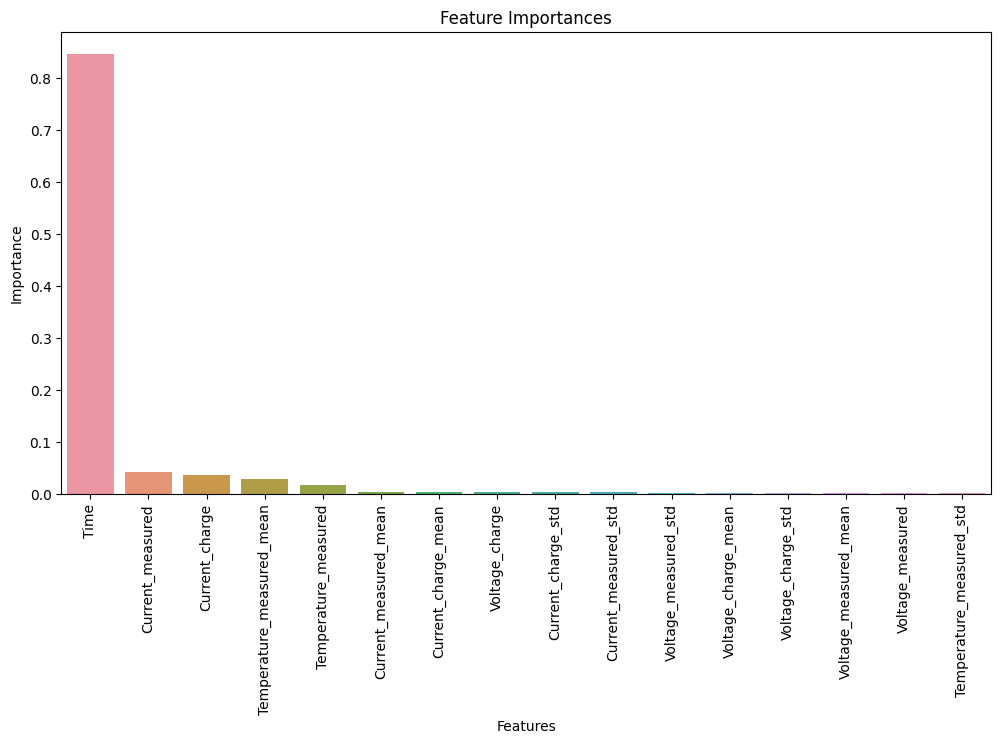

In [12]:
# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=train_X.columns[indices], y=importances[indices])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

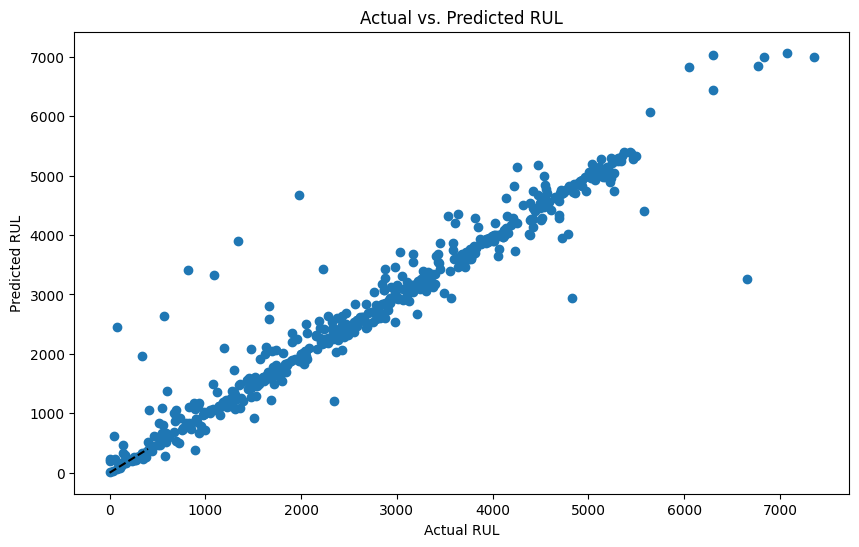

In [13]:
# Plot actual vs. predicted RUL
plt.figure(figsize=(10, 6))
plt.scatter(test_y, preds)
plt.plot([0, 400], [0, 400], '--k')  # Diagonal line for reference
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.show()

In [14]:

# Battery Management System Optimization
maintenance_threshold = 50  # Threshold for scheduling maintenance
charging_rate = 0.8  # Charging rate
temperature_threshold = 70  # Temperature threshold

for idx, predicted_rul in enumerate(preds):
    if predicted_rul < maintenance_threshold:
        # Schedule maintenance for batteries with predicted RUL below threshold
        schedule_maintenance(battery_index=idx)
    else:
        # Adjust charging rate based on predicted RUL
        adjust_charging_rate(battery_index=idx, rate=charging_rate)
        # Manage temperature based on predicted RUL
        manage_temperature(battery_index=idx, temperature_threshold=temperature_threshold)

Adjusting charging rate for battery 0 to 0.8
Managing temperature for battery 0 with threshold 70
Adjusting charging rate for battery 1 to 0.8
Managing temperature for battery 1 with threshold 70
Adjusting charging rate for battery 2 to 0.8
Managing temperature for battery 2 with threshold 70
Adjusting charging rate for battery 3 to 0.8
Managing temperature for battery 3 with threshold 70
Adjusting charging rate for battery 4 to 0.8
Managing temperature for battery 4 with threshold 70
Adjusting charging rate for battery 5 to 0.8
Managing temperature for battery 5 with threshold 70
Adjusting charging rate for battery 6 to 0.8
Managing temperature for battery 6 with threshold 70
Adjusting charging rate for battery 7 to 0.8
Managing temperature for battery 7 with threshold 70
Adjusting charging rate for battery 8 to 0.8
Managing temperature for battery 8 with threshold 70
Adjusting charging rate for battery 9 to 0.8
Managing temperature for battery 9 with threshold 70
Adjusting charging r

Gradient Boosting Model - MAE: 199.71677385022664, R2: 0.9339841574937301


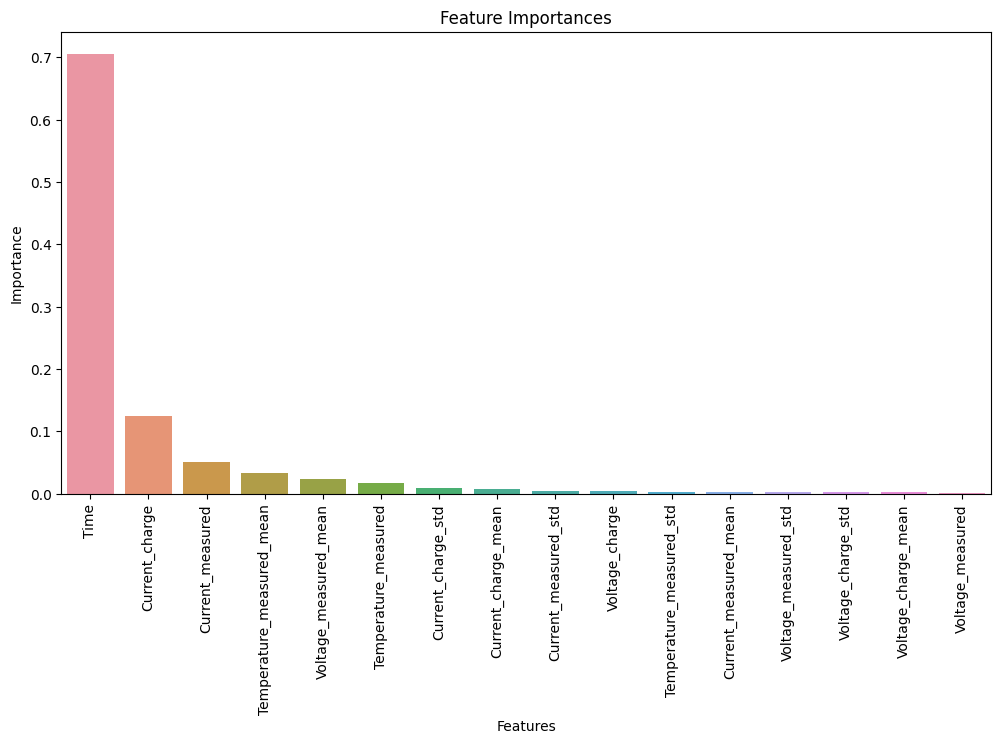

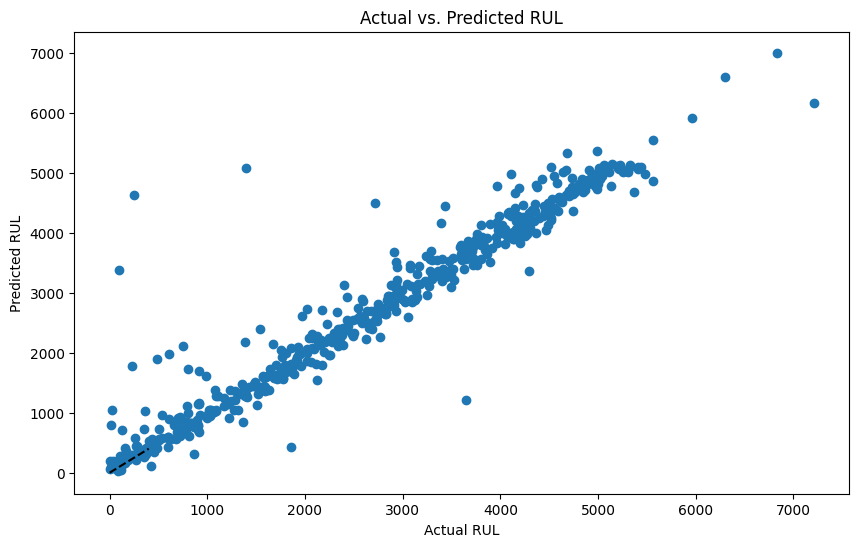

Adjusting charging rate for battery 0 to 0.8
Managing temperature for battery 0 with threshold 70
Adjusting charging rate for battery 1 to 0.8
Managing temperature for battery 1 with threshold 70
Adjusting charging rate for battery 2 to 0.8
Managing temperature for battery 2 with threshold 70
Adjusting charging rate for battery 3 to 0.8
Managing temperature for battery 3 with threshold 70
Adjusting charging rate for battery 4 to 0.8
Managing temperature for battery 4 with threshold 70
Adjusting charging rate for battery 5 to 0.8
Managing temperature for battery 5 with threshold 70
Adjusting charging rate for battery 6 to 0.8
Managing temperature for battery 6 with threshold 70
Adjusting charging rate for battery 7 to 0.8
Managing temperature for battery 7 with threshold 70
Adjusting charging rate for battery 8 to 0.8
Managing temperature for battery 8 with threshold 70
Adjusting charging rate for battery 9 to 0.8
Managing temperature for battery 9 with threshold 70
Adjusting charging r

In [9]:
# Train and evaluate models
gbr_model = GradientBoostingRegressor(random_state=0)
gbr_model.fit(train_X, train_y)
preds = gbr_model.predict(test_X)
mae = mean_absolute_error(test_y, preds)
r2 = r2_score(test_y, preds)
print(f"Gradient Boosting Model - MAE: {mae}, R2: {r2}")

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=train_X.columns[indices], y=importances[indices])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

# Plot actual vs. predicted RUL
plt.figure(figsize=(10, 6))
plt.scatter(test_y, preds)
plt.plot([0, 400], [0, 400], '--k')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.show()

# Battery Management System Optimization
maintenance_threshold = 50
charging_rate = 0.8
temperature_threshold = 70

for idx, predicted_rul in enumerate(preds):
    if predicted_rul < maintenance_threshold:
        schedule_maintenance(battery_index=idx)
    else:
        adjust_charging_rate(battery_index=idx, rate=charging_rate)
        manage_temperature(battery_index=idx, temperature_threshold=temperature_threshold)


XGBoost Model - MAE: 159.8533696642075, R2: 0.9574496453018724


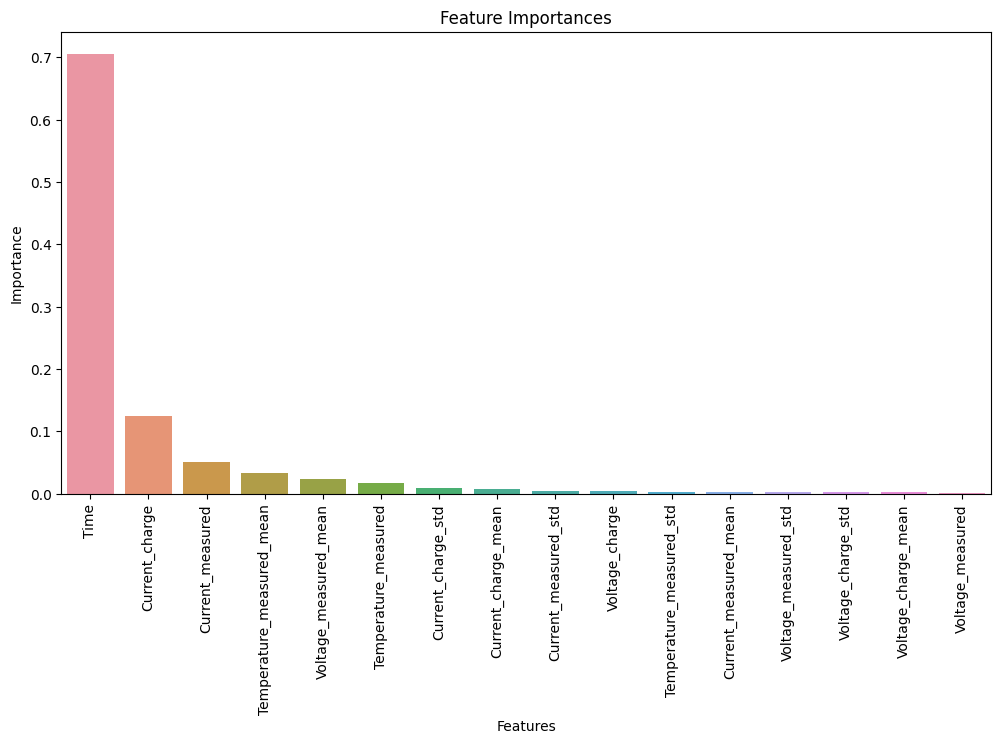

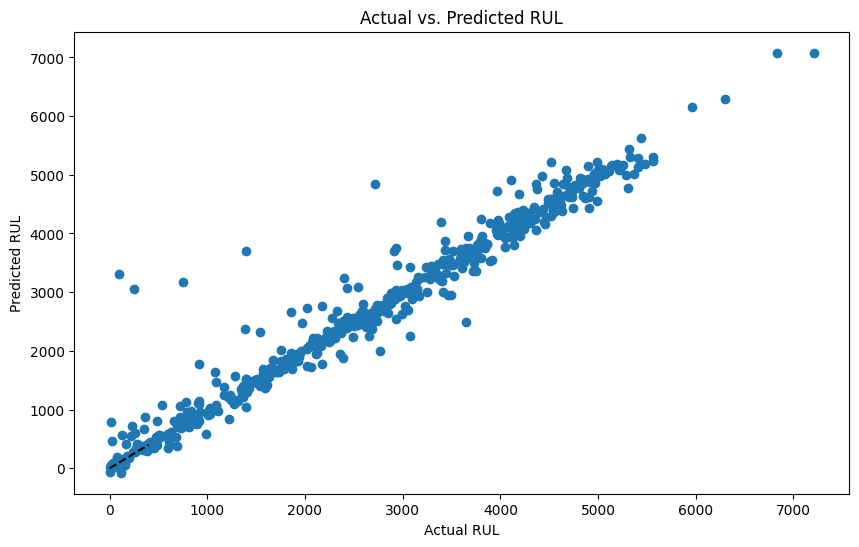

Adjusting charging rate for battery 0 to 0.8
Managing temperature for battery 0 with threshold 70
Adjusting charging rate for battery 1 to 0.8
Managing temperature for battery 1 with threshold 70
Adjusting charging rate for battery 2 to 0.8
Managing temperature for battery 2 with threshold 70
Adjusting charging rate for battery 3 to 0.8
Managing temperature for battery 3 with threshold 70
Adjusting charging rate for battery 4 to 0.8
Managing temperature for battery 4 with threshold 70
Adjusting charging rate for battery 5 to 0.8
Managing temperature for battery 5 with threshold 70
Adjusting charging rate for battery 6 to 0.8
Managing temperature for battery 6 with threshold 70
Adjusting charging rate for battery 7 to 0.8
Managing temperature for battery 7 with threshold 70
Adjusting charging rate for battery 8 to 0.8
Managing temperature for battery 8 with threshold 70
Adjusting charging rate for battery 9 to 0.8
Managing temperature for battery 9 with threshold 70
Adjusting charging r

In [10]:
#  Train and evaluate models
xgb_model = xgb.XGBRegressor(random_state=0)
xgb_model.fit(train_X, train_y)
preds = xgb_model.predict(test_X)
mae = mean_absolute_error(test_y, preds)
r2 = r2_score(test_y, preds)
print(f"XGBoost Model - MAE: {mae}, R2: {r2}")

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=train_X.columns[indices], y=importances[indices])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

# Plot actual vs. predicted RUL
plt.figure(figsize=(10, 6))
plt.scatter(test_y, preds)
plt.plot([0, 400], [0, 400], '--k')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs. Predicted RUL')
plt.show()

# Battery Management System Optimization
maintenance_threshold = 50
charging_rate = 0.8
temperature_threshold = 70

for idx, predicted_rul in enumerate(preds):
    if predicted_rul < maintenance_threshold:
        schedule_maintenance(battery_index=idx)
    else:
        adjust_charging_rate(battery_index=idx, rate=charging_rate)
        manage_temperature(battery_index=idx, temperature_threshold=temperature_threshold)


RandomForest Model - MAE: 158.9923133392541, R2: 0.9402040639504742
GradientBoosting Model - MAE: 199.71677385022664, R2: 0.9339841574937301
XGBoost Model - MAE: 159.8533696642075, R2: 0.9574496453018724


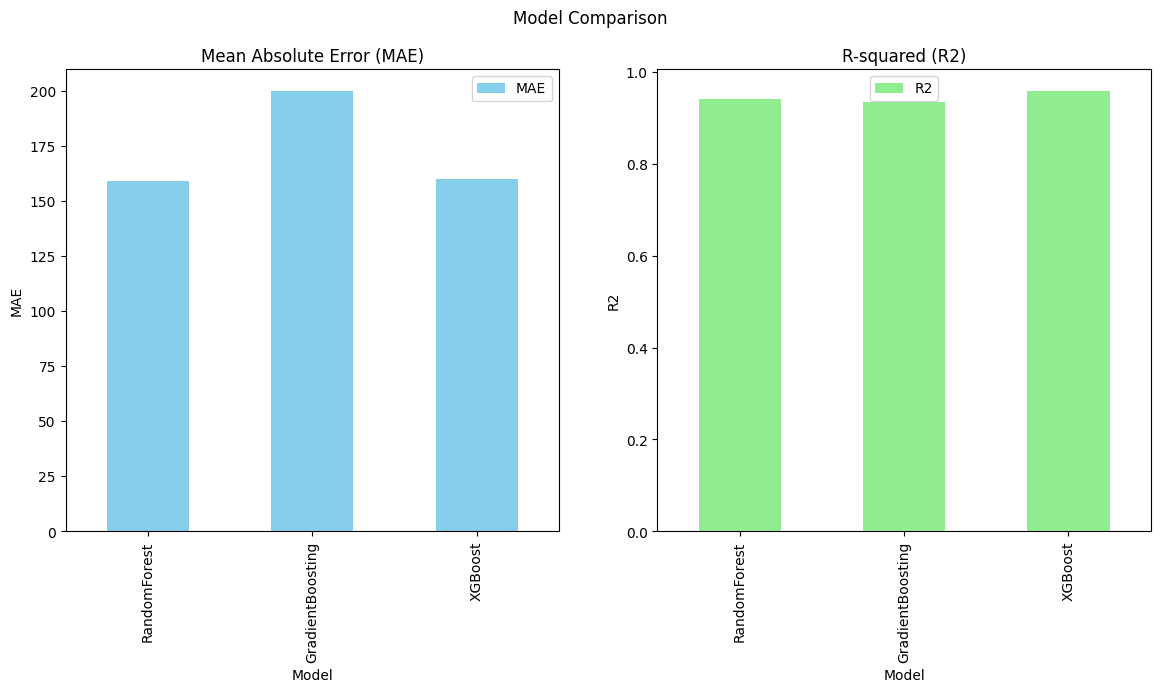

In [8]:

# Train and evaluate models
models = {
    "RandomForest": RandomForestRegressor(random_state=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=0),
    "XGBoost": xgb.XGBRegressor(random_state=0)
}

results = {}

for name, model in models.items():
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    mae = mean_absolute_error(test_y, preds)
    r2 = r2_score(test_y, preds)
    results[name] = {"MAE": mae, "R2": r2}
    print(f"{name} Model - MAE: {mae}, R2: {r2}")

# Plot comparison of MAE and R2 scores
metrics_df = pd.DataFrame(results).T
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MAE plot
metrics_df[['MAE']].plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Mean Absolute Error (MAE)')
axes[0].set_ylabel('MAE')
axes[0].set_xlabel('Model')
axes[0].legend(loc='best')

# R2 plot
metrics_df[['R2']].plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('R-squared (R2)')
axes[1].set_ylabel('R2')
axes[1].set_xlabel('Model')
axes[1].legend(loc='best')

plt.suptitle('Model Comparison')
plt.show()